In [1]:
%load_ext autoreload

In [19]:
%autoreload

import h2o
import pandas as pd
import seaborn as sns

from h2o.automl import H2OAutoML
from featurewiz import FeatureWiz

In [17]:
## Read data ##
A_train_target = pd.read_parquet('data/A/parquet/train_targets.parquet')
A_test = pd.read_parquet('data/A/parquet/X_test_estimated.parquet')
A_train_estimated = pd.read_parquet('data/A/parquet/X_train_estimated.parquet')
A_train_observed = pd.read_parquet('data/A/parquet/X_train_observed.parquet')

B_train_target = pd.read_parquet('data/B/parquet/train_targets.parquet')
B_test = pd.read_parquet('data/B/parquet/X_test_estimated.parquet')
B_train_estimated = pd.read_parquet('data/B/parquet/X_train_estimated.parquet')
B_train_observed = pd.read_parquet('data/B/parquet/X_train_observed.parquet')

C_train_target = pd.read_parquet('data/C/parquet/train_targets.parquet')
C_test = pd.read_parquet('data/C/parquet/X_test_estimated.parquet')
C_train_estimated = pd.read_parquet('data/C/parquet/X_train_estimated.parquet')
C_train_observed = pd.read_parquet('data/C/parquet/X_train_observed.parquet')
###############

## Concatinate train data ##
A_train_concat = pd.concat([A_train_observed, A_train_estimated], axis=0)
B_train_concat = pd.concat([B_train_observed, B_train_estimated], axis=0)
C_train_concat = pd.concat([C_train_observed, C_train_estimated], axis=0)

# Set index to date_forecast
A_train_concat.set_index('date_forecast', inplace=True)
B_train_concat.set_index('date_forecast', inplace=True)
C_train_concat.set_index('date_forecast', inplace=True)

# Drop date_calc column
A_train_concat.drop(columns=['date_calc'], inplace=True)
B_train_concat.drop(columns=['date_calc'], inplace=True)
C_train_concat.drop(columns=['date_calc'], inplace=True)
############################

## Format test data to same as train data ##
A_test.set_index('date_forecast', inplace=True)
B_test.set_index('date_forecast', inplace=True)
C_test.set_index('date_forecast', inplace=True)

# Drop date_calc column
A_test.drop(columns=['date_calc'], inplace=True)
B_test.drop(columns=['date_calc'], inplace=True)
C_test.drop(columns=['date_calc'], inplace=True)
############################################

## Cast train_target's RangeIndex to DatetimeIndex ##
A_train_target.set_index('time', inplace=True)
B_train_target.set_index('time', inplace=True)
C_train_target.set_index('time', inplace=True)
#####################################################

## Add 'pv_measurement' column from train_target to train data ##
A_train_concat['pv_measurement'] = A_train_target['pv_measurement']
B_train_concat['pv_measurement'] = B_train_target['pv_measurement']
C_train_concat['pv_measurement'] = C_train_target['pv_measurement']

# Remove all rows with NaN values in 'pv_measurement' column in train_concat
A_train_concat.dropna(subset=['pv_measurement'], inplace=True)
B_train_concat.dropna(subset=['pv_measurement'], inplace=True)
C_train_concat.dropna(subset=['pv_measurement'], inplace=True)
###################################################################

## Add the data from the three locations together ##
train_concat = pd.concat([A_train_concat, B_train_concat, C_train_concat], axis=0)
train_target = pd.concat([A_train_target, B_train_target, C_train_target], axis=0)
test = pd.concat([A_test, B_test, C_test], axis=0)
####################################################

## Check that every index in train_concat is in train_target ##
if len(train_concat.index) == len(train_target.index):
    print('Same length')
else:
    # Remove indicies in A_train_target that are not in A_train_concat
    train_target = train_target[train_target.index.isin(train_concat.index)]
    
    if len(train_concat.index) != len(train_target.index):
        print('Not same length')
################################################################

train_concat.index


Not same length


DatetimeIndex(['2019-06-02 22:00:00', '2019-06-02 23:00:00',
               '2019-06-03 00:00:00', '2019-06-03 01:00:00',
               '2019-06-03 02:00:00', '2019-06-03 03:00:00',
               '2019-06-03 04:00:00', '2019-06-03 05:00:00',
               '2019-06-03 06:00:00', '2019-06-03 07:00:00',
               ...
               '2023-04-30 14:00:00', '2023-04-30 15:00:00',
               '2023-04-30 16:00:00', '2023-04-30 17:00:00',
               '2023-04-30 18:00:00', '2023-04-30 19:00:00',
               '2023-04-30 20:00:00', '2023-04-30 21:00:00',
               '2023-04-30 22:00:00', '2023-04-30 23:00:00'],
              dtype='datetime64[ns]', name='date_forecast', length=92951, freq=None)

In [18]:
train_target.index

DatetimeIndex(['2019-06-02 22:00:00', '2019-06-02 23:00:00',
               '2019-06-03 00:00:00', '2019-06-03 01:00:00',
               '2019-06-03 02:00:00', '2019-06-03 03:00:00',
               '2019-06-03 04:00:00', '2019-06-03 05:00:00',
               '2019-06-03 06:00:00', '2019-06-03 07:00:00',
               ...
               '2023-04-30 14:00:00', '2023-04-30 15:00:00',
               '2023-04-30 16:00:00', '2023-04-30 17:00:00',
               '2023-04-30 18:00:00', '2023-04-30 19:00:00',
               '2023-04-30 20:00:00', '2023-04-30 21:00:00',
               '2023-04-30 22:00:00', '2023-04-30 23:00:00'],
              dtype='datetime64[ns]', name='time', length=99013, freq=None)

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /home/stinky/.local/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1xykhb9z
  JVM stdout: /tmp/tmp1xykhb9z/h2o_stinky_started_from_python.out
  JVM stderr: /tmp/tmp1xykhb9z/h2o_stinky_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_stinky_jsnj84
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.889 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


## Feature Engineering with Featurewiz

In [10]:
FEATURES = list(A_train_concat.columns)
FEATURES.remove('pv_measurement')

TARGET = 'pv_measurement'

X_train_wiz = A_train_concat[FEATURES]
y_train_wiz = A_train_concat[TARGET]

X_test_wiz = A_test[FEATURES]

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (34061, 46)
    Some column names had special characters which were removed...
#### Single_Label Re

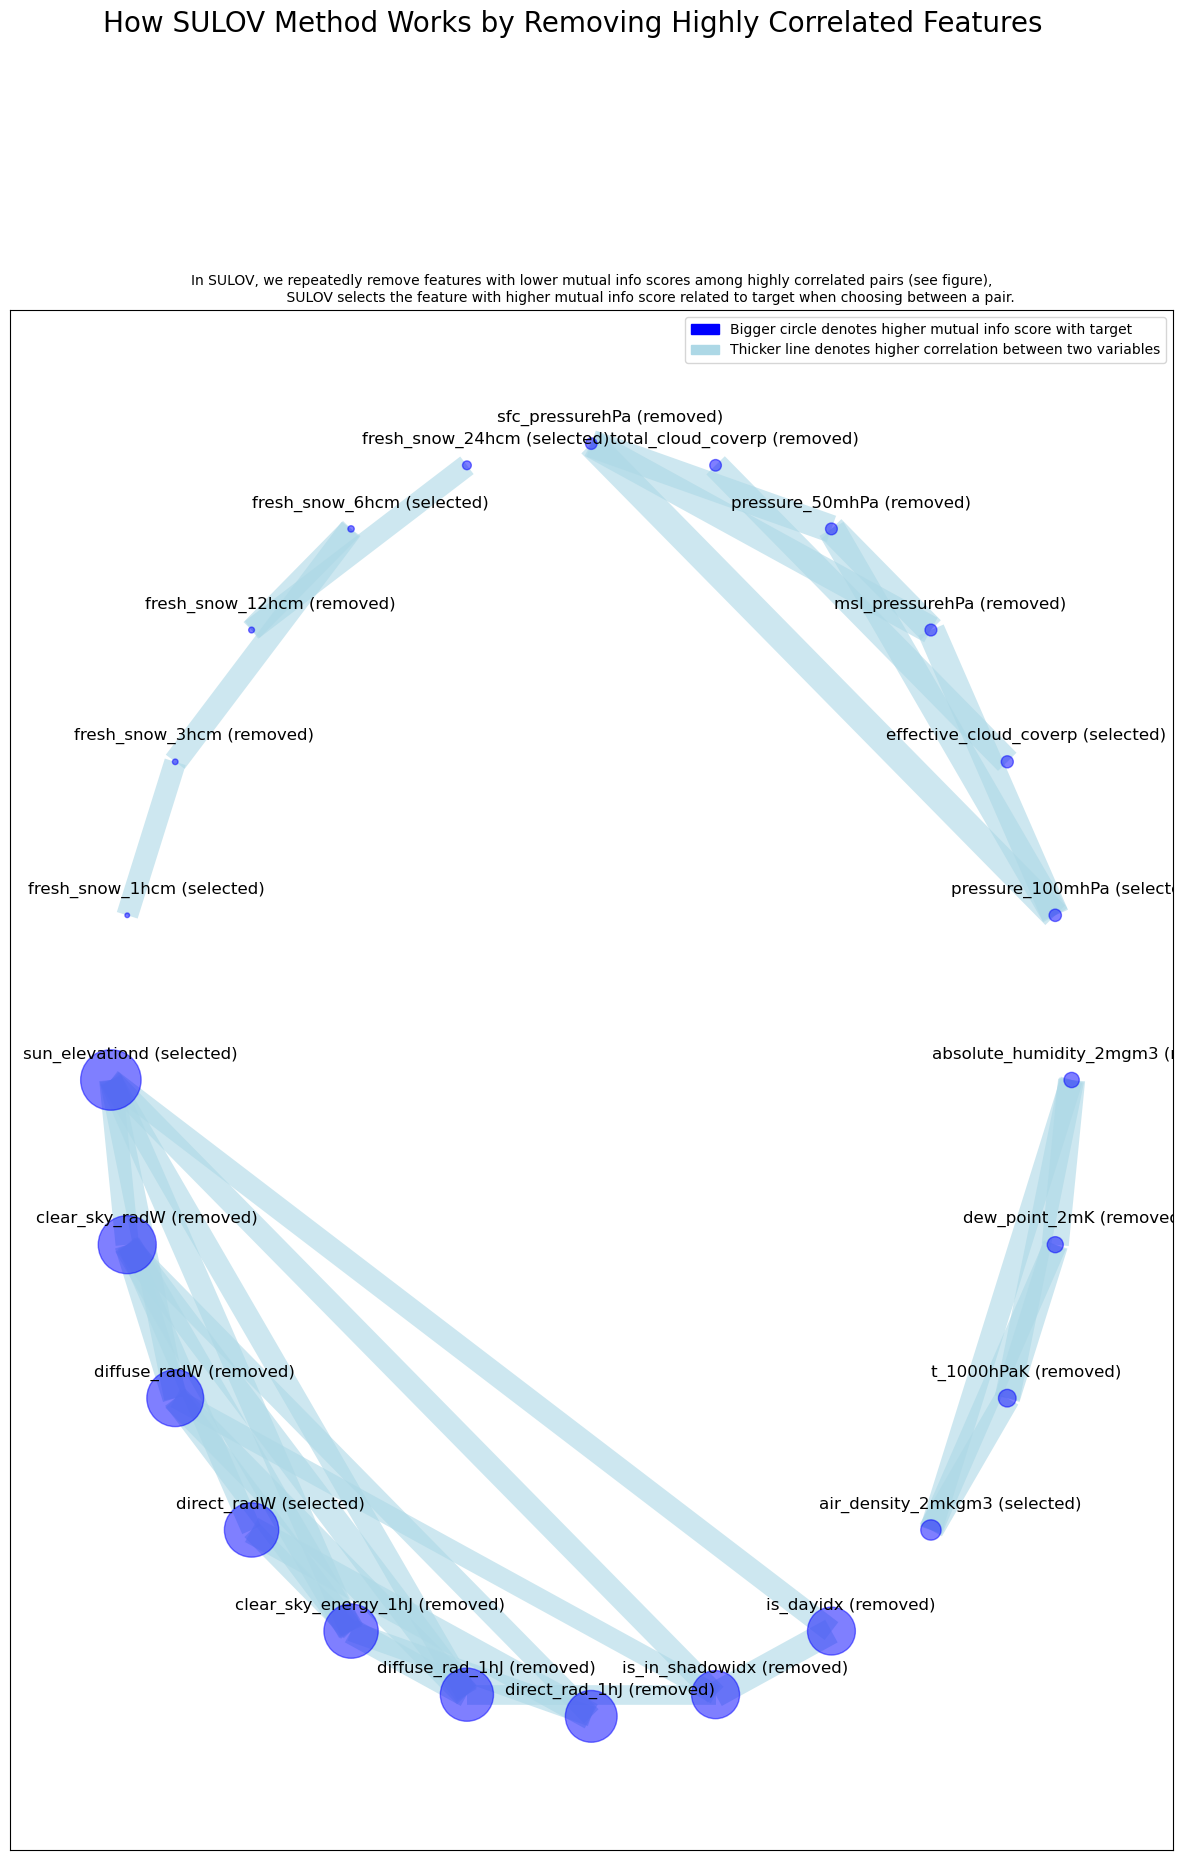

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 26
Final list of selected 26 vars after SULOV = ['ceiling_height_aglm', 'cloud_base_aglm', 'dew_or_rimeidx', 'precip_5minmm', 'precip_type_5minidx', 'prob_rimep', 'rain_waterkgm2', 'relative_humidity_1000hPap', 'snow_depthcm', 'snow_melt_10minmm', 'snow_waterkgm2', 'sun_azimuthd', 'super_cooled_liquid_waterkgm2', 'visibilitym', 'wind_speed_10mms', 'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams', 'sun_elevationd', 'direct_radW', 'air_density_2mkgm3', 'pressure_100mhPa', 'effective_cloud_coverp', 'fresh_snow_24hcm', 'fresh_snow_6hcm', 'fresh_snow_1hcm']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#########################################################################

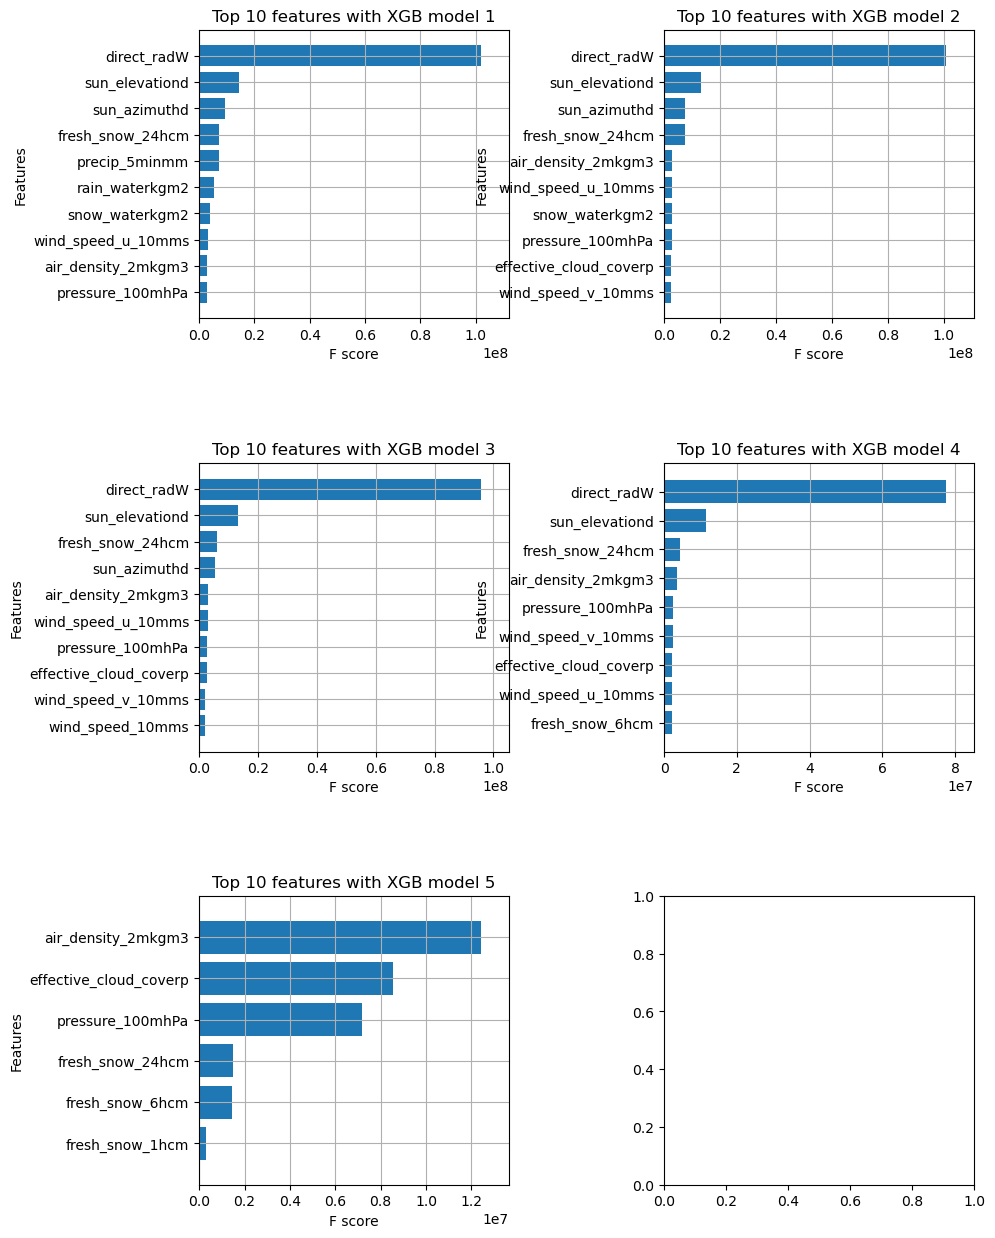

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 16 important features:
['direct_radW', 'sun_elevationd', 'sun_azimuthd', 'pressure_100mhPa', 'cloud_base_aglm', 'ceiling_height_aglm', 'wind_speed_u_10mms', 'air_density_2mkgm3', 'wind_speed_v_10mms', 'relative_humidity_1000hPap', 'effective_cloud_coverp', 'wind_speed_10mms', 'visibilitym', 'fresh_snow_24hcm', 'fresh_snow_6hcm', 'fresh_snow_1hcm']
Total Time taken for featurewiz selection = 15 seconds
Output contains a list of 16 important features and a train dataframe
    Time taken to create entire pipeline = 14 second(s)


In [11]:
fwiz = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None)
X_train_wiz_selected = fwiz.fit_transform(X_train_wiz, y_train_wiz)
X_test_wiz_selected = fwiz.transform(X_test_wiz)
feats = fwiz.features

## AutoML with H2O

In [9]:
X_train = A_train_concat
y_train = A_train_target

X_test = A_test

# Convert to h2o frame
X_train = h2o.H2OFrame(X_train)
y_train = h2o.H2OFrame(y_train)
X_test = h2o.H2OFrame(X_test)

x = X_train.columns
y = 'pv_measurement'
# y_train[y] = y_train[y].asfactor()
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
%%time
aml = H2OAutoML(max_models=5, max_runtime_secs=12000)
aml.train(x=x, y=y, training_frame=X_train)

AutoML progress: |


15:59:04.125: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
15:59:22.745: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


15:59:24.554: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
15:59:50.600: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


16:00:03.411: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
16:01:29.59: _train param, Dropping unused columns: [snow_drift:idx, elevation:m]
16:01:30.103: _train param, Dropping unused columns: [snow_drift:idx, elevation:m]

███████████████████████████████████████████████████████| (done) 100%
CPU times: user 710 ms, sys: 69.2 ms, total: 779 ms
Wall time: 2min 28s


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),2/2
# DRF base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [11]:
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20231011_155904,409.241,167478,184.965,nan,167478
StackedEnsemble_BestOfFamily_1_AutoML_3_20231011_155904,411.158,169051,186.285,nan,169051
DRF_1_AutoML_3_20231011_155904,418,174724,188.746,0.650186,174724
GBM_1_AutoML_3_20231011_155904,421.502,177664,190.568,nan,177664
XGBoost_1_AutoML_3_20231011_155904,444.334,197433,200.752,nan,197433
XGBoost_2_AutoML_3_20231011_155904,445.821,198756,200.834,nan,198756
GLM_1_AutoML_3_20231011_155904,516.969,267257,298.129,nan,267257
